In [ ]:
import torch
from torch import nn
from torch import optim

import numpy as np
from numpy import random
import re
import time

!pip install conllu
import conllu

In [ ]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

# Model Implementation

За основу взята модель из статьи [Morphosyntactic Tagging with a Meta-BiLSTM Model over Context Sensitive Token Encodings](https://arxiv.org/pdf/1805.08237.pdf).

In [ ]:
class Masking(nn.Module):
  def __init__(self, list_of_characters, device):
    self.chars = list(list_of_characters)
    self.chars_dict = {i:ind for ind, i in enumerate(self.chars)}
    self.size_vocab = len(self.chars)
    self.device = device
  
  def split_elem(self, input_string):
    return [i for i in input_string]
  
  def mask_elem(self, input_string):
    chars = self.split_elem(input_string)
    res = np.zeros(len(input_string))
    for ind, char in enumerate(chars):
      try:
        ind_char = self.chars_dict[char]
        res[ind] = ind_char
      except:
        ind_char = len(self.chars)
    return torch.tensor(res).to(device).to(torch.int64)
  
  def mask_batch(self, strings):
    res = []
    for input_string in strings:
      res += [self.mask_elem(input_string)]
    return res
  
  def unmask_elem(self, ind_list):
    out = ""
    for ind in ind_list:
      if ind < len(self.chars):
        out += self.chars[int(ind)]
    return out

  def unmask_batch(self, input_lists):
    res = []
    for ind_list in input_lists:
      res += [self.unmask_elem(ind_list)]
    return res

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, device,
                 dropout=0.2,
                 bidirectional=True):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = None
        if emb_dim is not None:
            self.embedding = nn.Embedding(input_dim, emb_dim)
            self.rnn = nn.LSTM(emb_dim,
                               hid_dim,
                               n_layers,
                               dropout=dropout,
                               bidirectional=bidirectional)
        else:
            self.rnn = nn.LSTM(input_dim,
                               hid_dim,
                               n_layers,
                               dropout=dropout,
                               bidirectional=bidirectional)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, src):
        output = []
        if self.embedding is not None:
            for i in src:
                output.append(self.dropout(self.embedding(i)))
        else:
            output = src
        out = []
        for i in output:
            out.append(self.rnn(i.view(i.shape[0], 1, i.shape[-1]))[0])
        return out

    
class MLP(nn.Module):
    def __init__(self, input_dim, out_dim, device, dimensions=[]):
        super().__init__()
        self.input_dim = input_dim
        self.out_dim = out_dim
        if dimensions is None:
            dimensions = []
        dimensions = [input_dim] + dimensions
        layers = []
        for ind, dim in enumerate(dimensions[:-1]):
            layers.append(nn.Linear(dim, dimensions[ind+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dimensions[-1], out_dim))
        self.seq = torch.nn.Sequential(*layers)
        self.out_dim = out_dim
        self.device = device
        
    def forward(self, src):
        output = []
        for i in range(len(src)):
            cur_output = torch.zeros((src[i].shape[0], self.out_dim)).to(self.device)
            for j in range(len(src[i])):
                cur_output[j] = self.seq(src[i][j])
            output.append(cur_output)
        return output

    
class BiLSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, out_dim, n_layers, device,
                 dropout=0.2,
                 bidirectional=True, dimensions=[]):
        super().__init__()
        
        self.encoder = Encoder(input_dim, emb_dim, hid_dim, n_layers, device,
                               dropout=dropout,
                               bidirectional=bidirectional)
        if bidirectional:
            input_dim_mlp = hid_dim * 2
        else:
            input_dim_mlp = hid_dim
        self.mlp = MLP(input_dim_mlp, out_dim, device, dimensions)
        self.device = device
        
    def forward(self, src):
        out = []
        out = self.encoder(src)
        out = self.mlp(out)
        return out

class BiLSTM_char(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, out_dim, n_layers, device,
                 dropout=0.2,
                 bidirectional=True, dimensions=[]):
        super().__init__()
        
        self.encoder = Encoder(input_dim, emb_dim, hid_dim, n_layers, device,
                               dropout=dropout,
                               bidirectional=bidirectional)
        if bidirectional:
            input_dim_mlp = hid_dim * 4
        else:
            input_dim_mlp = hid_dim * 2
        self.mlp = MLP(input_dim_mlp, out_dim, device, dimensions)
        self.device = device
        
    def forward(self, src, split_into_words):
        out = self.encoder(src)
        out_split = []
        for i in range(len(src)):
            cur_split = split_into_words[i]
            cur = torch.zeros((len(cur_split), out[i].shape[2] * 2)).to(self.device)
            for ind, (start, end) in enumerate(cur_split):
                cur[ind] = torch.cat([out[i][start], out[i][end-1]], dim=1)
            out_split.append(cur)
        out = self.mlp(out_split)
        return out


class MetaBiLSTM(nn.Module):
    def __init__(self, char_model, word_model, meta):
        super().__init__()
        
        self.char_model = char_model
        self.word_model = word_model
        self.meta = meta
        
    def forward(self, src):
        pos_w = self.word_model(src[2])
        pos_c = self.char_model(src[0], src[1])
        inp = [torch.cat([pos_c[ind], i], dim=-1) for ind, i in enumerate(pos_w)]
        out = self.meta(inp)
        return out

In [ ]:
def calculate_criterion(trg, out, criterion):
    s = 0
    for ind, i in enumerate(out):
        s += criterion(i, trg[ind].view(-1)) / len(trg)
    return s

def train(model, train_src, train_trg,
          batch_size,
          criterion,
          clip,
          device,
          train_history=None,
          valid_history=None):
    model.train()
    model.to(device)
    
    epoch_loss = 0
    history = []
    indexes = [i for i in range(len(train_src[0]))]
    indexes = np.random.permutation(indexes)
    indexes = np.array_split(indexes, len(indexes) // batch_size + 1)
    
    optimizer_char = optim.Adam(model.char_model.parameters(), lr=1e-3)
    optimizer_words = optim.Adam(model.word_model.parameters(), lr=1e-3)
    optimizer_meta = optim.Adam(model.meta.parameters(), lr=1e-3)
    
    for i, idx in enumerate(indexes):
        src_0 = [train_src[0][i].to(device) for i in idx]
        src_1 = [train_src[1][i] for i in idx]
        src_2 = [train_src[2][i].to(device) for i in idx]
        src = (src_0, src_1, src_2)
        trg = [train_trg[i].to(device) for i in idx]
        
        optimizer_char.zero_grad()
        output = model.char_model(src[0], src[1])
        output = [i.to(device) for i in output]
        loss = calculate_criterion(trg, output, criterion)
        loss.backward()        
        torch.nn.utils.clip_grad_norm_(model.char_model.parameters(), clip)
        optimizer_char.step()
        
        optimizer_words.zero_grad()
        output = model.word_model(src[2])
        output = [i.to(device) for i in output]
        loss = calculate_criterion(trg, output, criterion)
        loss.backward()        
        torch.nn.utils.clip_grad_norm_(model.word_model.parameters(), clip)
        optimizer_words.step()

        optimizer_meta.zero_grad()
        output = model(src)
        output = [i.to(device) for i in output]
        loss = calculate_criterion(trg, output, criterion)
        loss.backward()        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer_meta.step()
        
        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()        
    return epoch_loss / len(indexes)
  
def evaluate(model, val_src, val_trg, batch_size, device, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
            indexes = [i for i in range(len(val_trg))]
            indexes = np.random.permutation(indexes)
            indexes = np.array_split(indexes, len(indexes) // batch_size + 1)
            for idx in indexes:
                src_0 = [val_src[0][i].to(device) for i in idx]
                src_1 = [val_src[1][i] for i in idx]
                src_2 = [val_src[2][i].to(device) for i in idx]
                trg = [val_trg[i].to(device) for i in idx]
                src = (src_0, src_1, src_2)
                output = model(src)
                output = [i.to(device) for i in output]
                loss = calculate_criterion(trg, output, criterion)
                epoch_loss += loss.item()
    return epoch_loss / len(indexes)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

# Dataset Preprocessing

In [ ]:
with open("ru_syntagrus-ud-train.conllu", 'r') as f:
    data = f.read()
train_sentences = conllu.parse(data)
len(train_sentences)

48814

In [ ]:
START_TOKEN = "<"
END_TOKEN = ">"
rus_re = re.compile(r'[а-яА-ЯёЁ]+')
def extract_sequence(sentence):
    prev = 0
    src_char, src_split, src_word = [], [], []
    trg = []
    for ind, token in enumerate(sentence):
        if rus_re.fullmatch(token['form']):
            new = [i for i in token['form'].lower()]
            src_char += new
            cur_ind = prev + len(new) - 1
            src_split += [(prev, cur_ind)]
            prev = cur_ind + 1
            src_word += [token['form'].lower()]
            trg.append(token['upos'])
    return src_char, src_split, src_word, trg
            

def get_dataset(sentences):
    src_char, src_split, src_word, trg = [], [], [], []
    for sentence in sentences:
        cur_src_char, cur_src_split, cur_src_word, cur_trg = extract_sequence(sentence)
        if len(cur_trg) > 0:
          src_char.append(cur_src_char)
          src_split.append(cur_src_split)
          src_word.append(cur_src_word)
          trg.append(cur_trg)
    return (src_char, src_split, src_word), trg

In [ ]:
src, trg = get_dataset(train_sentences[:40000])

In [ ]:
device = torch.device("cuda:0")

In [ ]:
list_of_chars = list(set().union(*[set(i) for i in src[0]]))
mask_chars = Masking(list_of_chars, device)
list_of_words = list(set().union(*[set(i) for i in src[2]]))
mask_words = Masking(list_of_words, device)
list_of_upos = list(set().union(*[set(i) for i in trg]))
mask_upos = Masking(list_of_upos, device)

In [ ]:
src_0 = mask_chars.mask_batch(src[0])
src_2 = mask_words.mask_batch(src[2])
src = (src_0, src[1], src_2)
trg = mask_upos.mask_batch(trg)

In [ ]:
emb_dim = 100
hid_dim = 100
n_layers = 1
out_dim = mask_upos.size_vocab
dimensions = [128, 32]

word_model = BiLSTM(mask_words.size_vocab, emb_dim, hid_dim, out_dim, n_layers, device,
                 dropout=0.2,
                 bidirectional=True, dimensions=dimensions).to(device)
char_model = BiLSTM_char(mask_chars.size_vocab, emb_dim, hid_dim, out_dim, n_layers, device,
                 dropout=0.2,
                 bidirectional=True, dimensions=dimensions).to(device)
meta = BiLSTM(2 * out_dim, None, hid_dim, out_dim, n_layers, device,
                 dropout=0.2,
                 bidirectional=True, dimensions=dimensions).to(device)
model = MetaBiLSTM(char_model, word_model, meta).to(device)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
criterion = nn.CrossEntropyLoss()

BATCH_SIZE = 128

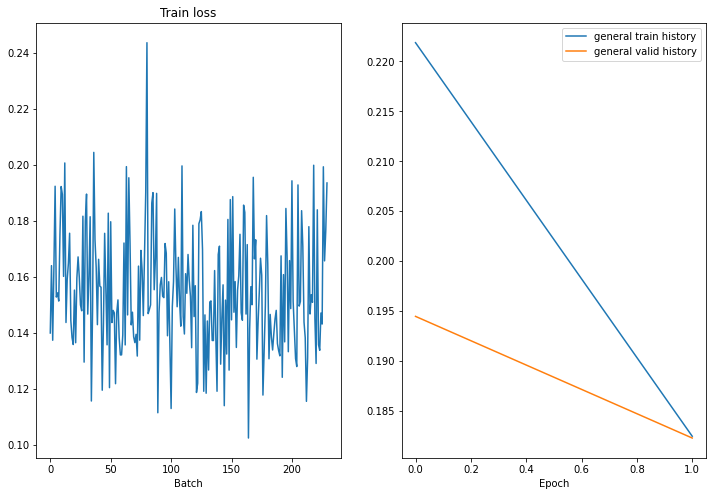

Epoch: 03 | Time: 34m 17s
	Train Loss: 0.154 | Train PPL:   1.167
	 Val. Loss: 0.177 |  Val. PPL:   1.194


In [16]:
%matplotlib inline
train_history = []
valid_history = []

N_EPOCHS = 3
CLIP = 1

best_valid_loss = float('inf')
valid_loss = 0
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, (src[0][:-10000], src[1][:-10000], src[2][:-10000]), trg[:-10000], BATCH_SIZE, criterion, CLIP, device, train_history, valid_history)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    valid_loss = evaluate(model, (src[0][-10000:-5000], src[1][-10000:-5000], src[2][-10000:-5000]), trg[-10000:-5000], BATCH_SIZE, device, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')

In [ ]:
res = model((src[0][-50:], src[1][-50:], src[2][-50:]))
[i.argmax(-1) for i in res][4]

tensor([13,  4, 13, 14, 14,  5], device='cuda:0')

In [41]:
test_src = (src[0][-5000:], src[1][-5000:], src[2][-5000:])
test_trg = trg[-5000:]

In [81]:
def get_accuracy(out, trg):
  s = 0
  n = 0
  for ind_token, j in enumerate(trg):
    s += out[ind_token].argmax() == j
    n += 1
  return s / n

In [82]:
model.eval()
epoch_loss = 0
history = []
criterion = lambda x, y: get_accuracy(x,y)
batch_size = 128
with torch.no_grad():
        indexes = [i for i in range(len(test_trg))]
        indexes = np.random.permutation(indexes)
        indexes = np.array_split(indexes, len(indexes) // batch_size + 1)
        for idx in indexes:
            src_0 = [test_src[0][i].to(device) for i in idx]
            src_1 = [test_src[1][i] for i in idx]
            src_2 = [test_src[2][i].to(device) for i in idx]
            trg = [test_trg[i].to(device) for i in idx]
            src = (src_0, src_1, src_2)
            output = model(src)
            output = [i.to(device) for i in output]
            loss = calculate_criterion(trg, output, criterion)
            epoch_loss += loss.item()

In [84]:
epoch_loss/len(indexes) * 100

94.02956962585449